In [88]:

# Ignoring all warnings throughout the notebook
import warnings
warnings.filterwarnings('ignore')

In [89]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import xgboost as xgb

from collections import Counter
import sklearn

# Scikit-learn libraries for model building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Scikit-learn libraries for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import *


sklearn.__version__

'0.21.2'

In [90]:

data = pd.read_csv("train.csv", parse_dates=['DateTime'])
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [91]:
data.shape

(26729, 10)

In [92]:
test = pd.read_csv("test.csv", parse_dates=['DateTime'])
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [93]:
test.shape

(11456, 8)

# DateTime splitting

In [94]:


test['Year'] = test['DateTime'].map(lambda x: x.year)
test['Month'] = test['DateTime'].map(lambda x: x.month)
test['Date'] = test['DateTime'].map(lambda x: x.day)
test['Hour'] = test['DateTime'].map(lambda x: x.hour)
test['Minute'] = test['DateTime'].map(lambda x: x.minute)

data['Year'] = data['DateTime'].map(lambda x: x.year)
data['Month'] = data['DateTime'].map(lambda x: x.month)
data['Date'] = data['DateTime'].map(lambda x: x.day)
data['Minute'] = data['DateTime'].map(lambda x: x.minute)
data['Hour'] = data['DateTime'].map(lambda x: x.hour)

In [95]:
data=data.drop(labels=['DateTime'],axis=1)
test=test.drop(labels=['DateTime'],axis=1)

In [96]:
data.head()

,AnimalID,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Year,Month,Date,Minute,Hour
0,A671945,Hambone,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,2014,2,12,22,18
1,A656520,Emily,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,2013,10,13,44,12
2,A686464,Pearce,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2015,1,31,28,12
3,A683430,NaN,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,2014,7,11,9,19
4,A667013,NaN,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2013,11,15,52,12


# Exploratory data analysis


We start with exploratory data analysis. First, we look to see if we have outliers or missing data for each feature.

In [97]:
# Describe the dataset.
data.head()

,AnimalID,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Year,Month,Date,Minute,Hour
0,A671945,Hambone,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,2014,2,12,22,18
1,A656520,Emily,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,2013,10,13,44,12
2,A686464,Pearce,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2015,1,31,28,12
3,A683430,NaN,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,2014,7,11,9,19
4,A667013,NaN,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2013,11,15,52,12


In [98]:

data_counts = pd.DataFrame({'Column Count' : data.count(),
   ....:                      '% Percent of Total Data' : data.count().div(max(data.count())) * 100})

data_counts.round(1)

,Column Count,% Percent of Total Data
AnimalID,26729,100.0
Name,19038,71.2
OutcomeType,26729,100.0
OutcomeSubtype,13117,49.1
AnimalType,26729,100.0
SexuponOutcome,26728,100.0
AgeuponOutcome,26711,99.9
Breed,26729,100.0
Color,26729,100.0
Year,26729,100.0


Our initial look at the data reveals 26,729 rows. Name is included for 71.2% of the data. 
A large quantity of OutcomeSubtype data is missing, which we worked to quantify below. 
Aside from these two columns, we had at least 99.9% of the data in every other column.
We are choosing not to use the Name variable moving forward.We feel that this level of sparsity within Name will not help us predict animal outcomes. 

# Class Variable

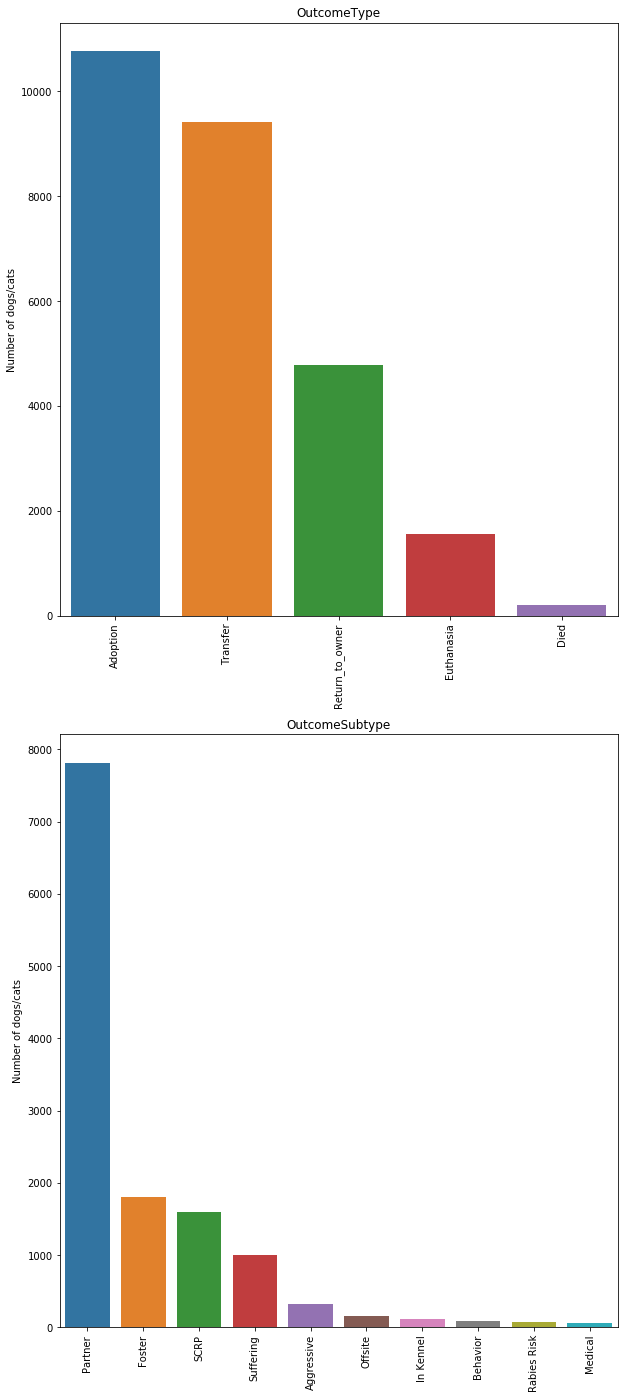

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [99]:
# Obtain headers.
headers = data.dtypes.index

# Categorical headers of classes.
cat_headers = ['OutcomeType', 'OutcomeSubtype']

# Plot paretos of top 10 values in each column.
fig, ax = plt.subplots(len(cat_headers[0:]), 1, figsize=(10, len(cat_headers)*12))
for i, column in enumerate(cat_headers[0:]):
    to_plot=data[column].value_counts().head(10)
    plot=sns.barplot(x=to_plot.index, y=to_plot, ax=ax[i])
    plot.set_xticklabels(to_plot.index, rotation=90)
    plot.set_title(column)
    plot.set_ylabel("Number of dogs/cats")
    plt.figure(figsize=(10,5))
fig.show()

In [100]:
data.groupby(['OutcomeType', 'OutcomeSubtype']).size().reset_index(name='Count')

,OutcomeType,OutcomeSubtype,Count
0,Adoption,Barn,1
1,Adoption,Foster,1800
2,Adoption,Offsite,165
3,Died,At Vet,4
4,Died,Enroute,8
5,Died,In Foster,52
6,Died,In Kennel,114
7,Died,In Surgery,3
8,Euthanasia,Aggressive,320
9,Euthanasia,Behavior,86


In [101]:
data_sub = data[data['OutcomeSubtype'].isnull()]
data_sub.head()

,AnimalID,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Year,Month,Date,Minute,Hour
0,A671945,Hambone,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,2014,2,12,22,18
8,A671784,Lucy,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,2014,2,4,17,17
11,A666320,NaN,Adoption,NaN,Dog,Spayed Female,2 years,Miniature Schnauzer Mix,Silver,2013,11,4,48,14
13,A704702,Scooter,Return_to_owner,NaN,Dog,Neutered Male,2 years,Yorkshire Terrier Mix,Black/Red,2015,6,8,30,16
14,A688584,Preston,Return_to_owner,NaN,Dog,Neutered Male,1 year,Great Pyrenees Mix,White/Cream,2015,11,25,0,15


In [102]:
data_sub.shape

(13612, 14)

In [103]:
data_sub.groupby(['OutcomeType']).size().reset_index(name='Count')

,OutcomeType,Count
0,Adoption,8803
1,Died,16
2,Euthanasia,1
3,Return_to_owner,4786
4,Transfer,6


From the data in the table above, we surmise that it is possible the majority of the subtype null data is from the Return to Owner or Adoption outcome type data. We will examine this further below.

Of all the null entries in OutcomeSubtype,

8803 are of OutcomeType- Adoption,
4786 are of OutcomeType- Return_to_owner,
16   are of OutcomeType- Died,
6    are of OutcomeType- Transfer,
1    is of OutcomeType - Euthanasia.

As we already have outcome subtypes for barn, foster, and offsite within adoption, we feel confident in assuming that these missing subtypes are simply the animals that were adopted. We will assume this is true and fill these null values with adopted.

As the return-to-owner outcome type also has no subtype, we will make the outcome subtype return to owner.

For the remaining 23 null outcome subtypes, we will label their subtype as other.

In [104]:
def subtype(x):
    if x['OutcomeType'] == 'Adoption' and pd.isnull(x['OutcomeSubtype']) : return 'Adopted'
    elif x['OutcomeType'] == 'Return_to_owner' and pd.isnull(x['OutcomeSubtype']): return 'Return to Owner'
    elif pd.isnull(x['OutcomeSubtype']) : return 'Other'
    else: return x['OutcomeSubtype']

data['OutcomeSubtype'] = data.apply(subtype, axis=1)

In [105]:
data.groupby(['OutcomeType', 'OutcomeSubtype']).size().reset_index(name='Count')

,OutcomeType,OutcomeSubtype,Count
0,Adoption,Adopted,8803
1,Adoption,Barn,1
2,Adoption,Foster,1800
3,Adoption,Offsite,165
4,Died,At Vet,4
5,Died,Enroute,8
6,Died,In Foster,52
7,Died,In Kennel,114
8,Died,In Surgery,3
9,Died,Other,16


# Feature Review

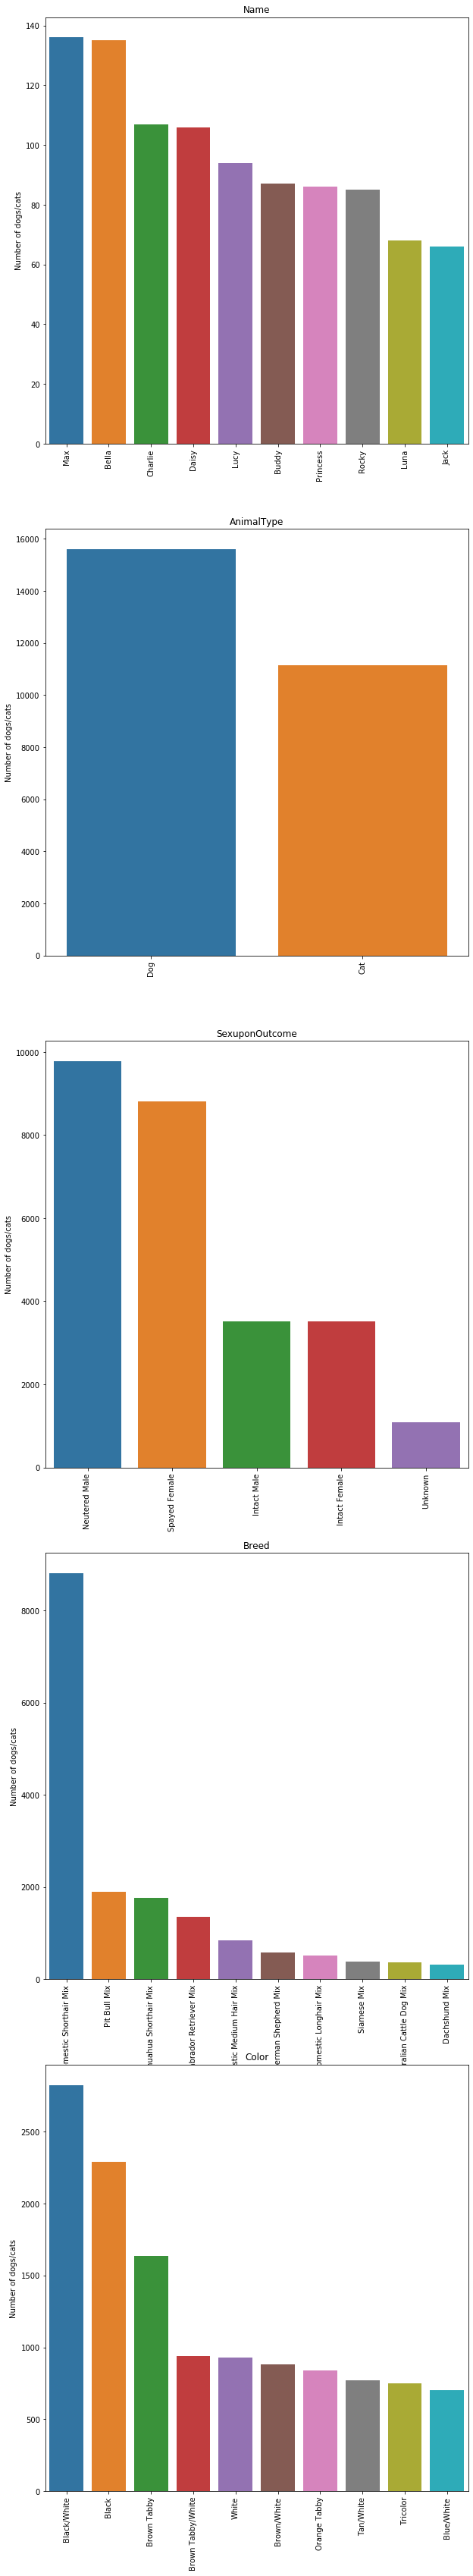

In [106]:
# Obtain headers.
headers = data.dtypes.index

# Not all of these are categorical variables.  
# We need categorical headers and continuous headers, with two different types of plots.

# Categorical headers of features.
cat_headers = ['Name', 'AnimalType', 'SexuponOutcome', 'Breed', 'Color']

# Plot paretos of top 10 values in each column.
fig, ax = plt.subplots(len(cat_headers[0:]), 1, figsize=(10, len(cat_headers)*12))
for i, column in enumerate(cat_headers[0:]):
    to_plot=data[column].value_counts().head(10)
    plot=sns.barplot(x=to_plot.index, y=to_plot, ax=ax[i])
    plot.set_xticklabels(to_plot.index, rotation=90)
    plot.set_title(column)
    plot.set_ylabel("Number of dogs/cats")
fig.show()

In [107]:
data_sex_dropna = data.dropna(subset=['SexuponOutcome'])
data_sex_outcome = data_sex_dropna.groupby(['OutcomeType', 'SexuponOutcome']).agg({'AnimalType':'size'}).rename(columns={'AnimalType':'# of Animals'}).reset_index()
data_sex_outcome

,OutcomeType,SexuponOutcome,# of Animals
0,Adoption,Intact Female,203
1,Adoption,Intact Male,158
2,Adoption,Neutered Male,5222
3,Adoption,Spayed Female,5186
4,Died,Intact Female,56
5,Died,Intact Male,79
6,Died,Neutered Male,19
7,Died,Spayed Female,18
8,Died,Unknown,25
9,Euthanasia,Intact Female,401


In [108]:
def convert_AgeuponOutcome_to_weeks(data):
    result = {}
    for k in data['AgeuponOutcome'].unique():
        if type(k) != type(""):
            result[k] = -1
        else:
            v1, v2 = k.split()
            if v2 in ["year", "years"]:
                result[k] = int(v1) * 1
            elif v2 in ["month", "months"]:
                result[k] = int(v1) / 12
            elif v2 in ["week", "weeks"]:
                result[k] = int(v1) / 52
            elif v2 in ["day", "days"]:
                result[k] = int(v1) / 365
                
    data['_AgeuponOutcome'] = data['AgeuponOutcome'].map(result).astype(float)
    data = data.drop('AgeuponOutcome', axis = 1)
                
    return data

data = convert_AgeuponOutcome_to_weeks(data)

test = convert_AgeuponOutcome_to_weeks(test)

Next, we look into the Age Upon Outcome feature variable. We believed that it is important to make the ages variable continuous, as opposed to categorical, as the relationship of age is continuous in nature. The most logical unit to standardize ages is weeks. 

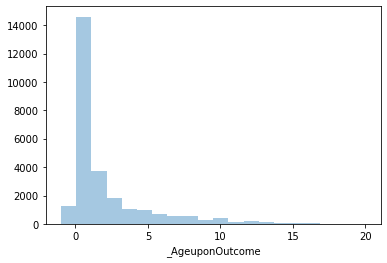

In [109]:
sns.distplot(data._AgeuponOutcome,bins=20, kde=False)

From the information above, we can see that a more likely outcome for younger animals is to be transfered or adopted, while older animals are more likely to be returned to their owner or euthanized.

In [110]:
def calc_age_category(x):
    if x  <3: return 'young'
    if x  <5 and x>=3: return 'young adult'
    if x  <10 and x>=5: return 'adult'
    return 'old'
data['_AgeuponOutcome']=data._AgeuponOutcome.apply(calc_age_category)

test['_AgeuponOutcome']=test._AgeuponOutcome.apply(calc_age_category)

In [111]:
data1_counts = pd.DataFrame({'Column Count' : data.count(),
   ....:                      '% Percent of Total Data' : data.count().div(max(data.count())) * 100})

data1_counts.round(1)

,Column Count,% Percent of Total Data
AnimalID,26729,100.0
Name,19038,71.2
OutcomeType,26729,100.0
OutcomeSubtype,26729,100.0
AnimalType,26729,100.0
SexuponOutcome,26728,100.0
Breed,26729,100.0
Color,26729,100.0
Year,26729,100.0
Month,26729,100.0


In [112]:
data['Name']=data['Name'].fillna('Timon')


Naming the unnamed dogs,cats as TIMON

# Breed

In [113]:
print ('Total number of breeds:', len(data['Breed'].unique()))
print ('Number of cat breeds:', len(data[data['AnimalType'] == 'Cat']['Breed'].unique()))
print ('Number of dog breeds:', len(data[data['AnimalType'] == 'Dog']['Breed'].unique()))


Total number of breeds: 1380
Number of cat breeds: 60
Number of dog breeds: 1320


Given the massive number of breeds (mostly for dogs) we may overfit w/ regard to breed. Here is the distribution of the (log) number of animals by breed for both animals. We can see there are a small number of breeds containing a large number of animals, and then many breeds with a very small number of animals.

In [114]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

In [115]:
Cat=data['OutcomeType']
le_res=le.fit_transform(data['OutcomeType'])
y=pd.DataFrame(le_res)
y.columns=['OutcomeType']


In [116]:
x=data.Breed.str.contains(pat="Mix", case=True,regex=True)
Breed=pd.DataFrame(x)
le_res=le.fit_transform(Breed)
Breed=pd.DataFrame(le_res)
Breed.columns=['Breed']
data=data.drop(labels=['Breed'],axis=1)
data=pd.concat([Breed,data],axis=1)

In [117]:
data.head

<bound method NDFrame.head of        Breed AnimalID        Name      OutcomeType   OutcomeSubtype  \
0          1  A671945     Hambone  Return_to_owner  Return to Owner   
1          1  A656520       Emily       Euthanasia        Suffering   
2          1  A686464      Pearce         Adoption           Foster   
3          1  A683430       Timon         Transfer          Partner   
4          0  A667013       Timon         Transfer          Partner   
5          0  A677334        Elsa         Transfer          Partner   
6          1  A699218       Jimmy         Transfer          Partner   
7          1  A701489       Timon         Transfer          Partner   
8          1  A671784        Lucy         Adoption          Adopted   
9          0  A677747       Timon         Adoption          Offsite   
10         1  A668402       Timon         Transfer             SCRP   
11         1  A666320       Timon         Adoption          Adopted   
12         1  A684601      Rocket         Adopt

# LabelEncoding

In [118]:
#Train set
le_res=le.fit_transform(data['_AgeuponOutcome'])
_AgeuponOutcome=pd.DataFrame(le_res)
_AgeuponOutcome.columns=['_AgeuponOutcome']
data=data.drop(labels=['_AgeuponOutcome'],axis=1)
data=pd.concat([_AgeuponOutcome,data],axis=1)

#Test set
le_res_test=le.fit_transform(test['_AgeuponOutcome'])
_AgeuponOutcome_test=pd.DataFrame(le_res_test)
_AgeuponOutcome_test.columns=['_AgeuponOutcome']
test=test.drop(labels=['_AgeuponOutcome'],axis=1)
test=pd.concat([_AgeuponOutcome_test,test],axis=1)

In [119]:
#Train set 
le_res=le.fit_transform(data['Breed'])
Breed=pd.DataFrame(le_res)
Breed.columns=['Breed']
data=data.drop(labels=['Breed'],axis=1)
data=pd.concat([Breed,data],axis=1)

#Test set
le_res_test=le.fit_transform(test['Breed'])
Breed_test=pd.DataFrame(le_res_test)
Breed_test.columns=['Breed']
test=test.drop(labels=['Breed'],axis=1)
test=pd.concat([Breed_test,test],axis=1)

In [120]:
data["SexuponOutcome"]=data["SexuponOutcome"].fillna("Unknown")

test["SexuponOutcome"]=test["SexuponOutcome"].fillna("Unknown")

In [121]:
#Train set
le_res=le.fit_transform(data['SexuponOutcome'])
SexuponOutcome=pd.DataFrame(le_res)
SexuponOutcome.columns=['SexuponOutcome']
data=data.drop(labels=['SexuponOutcome'],axis=1)
data=pd.concat([SexuponOutcome,data],axis=1)


In [122]:
#Test set
le_res_test=le.fit_transform(test['SexuponOutcome'])
SexuponOutcome_test=pd.DataFrame(le_res_test)
SexuponOutcome_test.columns=['SexuponOutcome']
test=test.drop(labels=['SexuponOutcome'],axis=1)
test=pd.concat([SexuponOutcome_test,test],axis=1)

In [123]:
data['AnimalType']=data['AnimalType'].apply(lambda x:1 if x in('Dog') else 0)

test['AnimalType']=test['AnimalType'].apply(lambda x:1 if x in('Dog') else 0)

In [124]:
data['Month']=data['Month'].apply(lambda x : 0 if x <4 else (1 if x <8 else (2)))

In [125]:
data['OutcomeType']=le.fit_transform(data['OutcomeType'])

In [126]:
corre=data.corr()
corre

,SexuponOutcome,Breed,_AgeuponOutcome,OutcomeType,AnimalType,Year,Month,Date,Minute,Hour
SexuponOutcome,1.000000,-0.043571,-0.035781,-0.316375,0.092184,0.064750,-0.040418,-0.019887,0.042274,0.121099
Breed,-0.043571,1.000000,0.034226,0.048857,-0.319317,0.022467,0.050743,0.004810,-0.019058,-0.040409
_AgeuponOutcome,-0.035781,0.034226,1.000000,-0.025823,-0.070797,-0.012944,0.012951,0.005532,-0.005235,0.019601
OutcomeType,-0.316375,0.048857,-0.025823,1.000000,-0.086064,-0.020392,0.007657,-0.002716,-0.084680,-0.252149
AnimalType,0.092184,-0.319317,-0.070797,-0.086064,1.000000,0.007345,-0.086570,-0.016706,0.052667,0.109835
Year,0.064750,0.022467,-0.012944,-0.020392,0.007345,1.000000,-0.358674,-0.011404,-0.029248,-0.065426
Month,-0.040418,0.050743,0.012951,0.007657,-0.086570,-0.358674,1.000000,0.027120,-0.011629,-0.022732
Date,-0.019887,0.004810,0.005532,-0.002716,-0.016706,-0.011404,0.027120,1.000000,-0.005663,-0.004590
Minute,0.042274,-0.019058,-0.005235,-0.084680,0.052667,-0.029248,-0.011629,-0.005663,1.000000,0.132265
Hour,0.121099,-0.040409,0.019601,-0.252149,0.109835,-0.065426,-0.022732,-0.004590,0.132265,1.000000


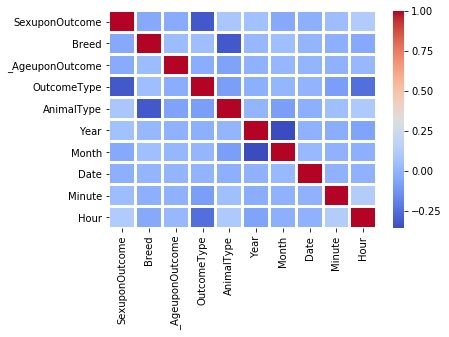

In [127]:
sns.heatmap(corre,linewidths=2, cmap="coolwarm")

# Dropping Unnecesary Columns

In [128]:
data=data.drop(labels=['AnimalID'],axis=1)

In [129]:
data=data.drop(labels=['OutcomeType'],axis=1)

In [130]:
data=data.drop(labels=['OutcomeSubtype','Color','Name'],axis=1)

test=test.drop(labels=['Color','Name'],axis=1)

In [131]:
data.head()

,SexuponOutcome,Breed,_AgeuponOutcome,AnimalType,Year,Month,Date,Minute,Hour
0,2,1,2,1,2014,0,12,22,18
1,3,1,2,0,2013,2,13,44,12
2,2,1,2,1,2015,0,31,28,12
3,1,1,2,0,2014,1,11,9,19
4,2,0,2,1,2013,2,15,52,12


# Splitting train and test

In [132]:
X=data

In [133]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=4)

# Importance of Features

# Logistic Regression 

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
classifier = LogisticRegression(penalty='l2',random_state = 0,class_weight='balanced',multi_class='multinomial', 
                                solver='lbfgs',n_jobs=-1)
selector = RFE(classifier, 5, step=1)
selector = selector.fit(X, y)
selector.support_
selector.ranking_

array([1, 1, 1, 1, 5, 2, 3, 4, 1])

In [135]:
from sklearn.linear_model import LogisticRegression

In [136]:
import pickle

In [137]:
filename = 'logistic_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [138]:
loaded_model = pickle.load(open(filename, 'rb'))

In [139]:
loaded_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=-1,
                   penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [140]:
y_pred=loaded_model.predict_proba(X_test)

In [141]:
ll = log_loss(y_test,y_pred)
ll

1.4594995225944294

# XGBOOST

In [170]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.feature_selection import RFE
model = xgb.XGBClassifier(objective='multi:softprob')
selector = RFE(model, 5, step=1)
selector = selector.fit(X, y)
selector.support_
selector.ranking_

array([1, 4, 1, 1, 2, 3, 5, 1, 1])

In [143]:
from xgboost import XGBClassifier
import xgboost as xgb

In [144]:
filename = 'xgboost_model.sav'
pickle.dump(model, open(filename, 'wb'))


In [145]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [146]:
y_pred=loaded_model.predict_proba(X_test)

In [147]:
ll = log_loss(y_test,y_pred)
ll

0.8691580911528276

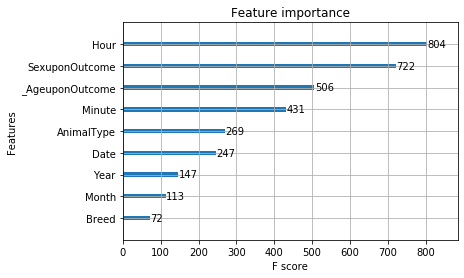

In [148]:
xgb.plot_importance(loaded_model)

# XGBOOST PARAMETER TUNING

In [149]:
HYPER_PARAMS = { 
 'learning_rate': 0.20,
 'n_estimators':0,
 'max_depth': 5,
 'subsample': 0.7,
 'colsample_bytree': 0.9,
 'max_delta_step': 1,
 'objective': 'multi:softmax',
 'nthread': 1,
 }

In [150]:
filename = 'xgboostparam_model.sav'
pickle.dump(model, open(filename, 'wb'))


In [151]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [152]:
y_pred=loaded_model.predict_proba(X_test)

In [153]:
print (log_loss(y_test,y_pred));

0.8691580911528276


# Naive Bayes

In [174]:
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
nv = GaussianNB()


In [175]:
filename = 'naive_model.sav'
pickle.dump(nv, open(filename, 'wb'))


In [176]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [177]:
y_pred=loaded_model.predict_proba(X_test)

In [178]:
ll = log_loss(y_test,y_pred)
ll

1.0993156117806615

# LightGBM

In [171]:
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
lgbm = LGBMClassifier(objective='multiclass', random_state=5)
selector = RFE(lgbm, 5, step=1)
selector=selector.fit(X, y)
selector.support_
selector.ranking_

array([1, 5, 2, 4, 1, 3, 1, 1, 1])

In [160]:
filename = 'lgbm_model.sav'
pickle.dump(lgbm, open(filename, 'wb'))

In [161]:
lgbmm = pickle.load(open(filename, 'rb'))
lgbmm.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=5, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [162]:
y_pred=lgbmm.predict_proba(X_test)

In [163]:
ll=log_loss(y_test,y_pred)
ll

0.8537600402307091

# Random Forest

In [172]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4,n_estimators =20,criterion = 'entropy',random_state = 0)
selector = RFE(clf, 5, step=1)
selector = selector.fit(X, y)
selector.support_
selector.ranking_

array([1, 4, 1, 1, 2, 3, 5, 1, 1])

In [165]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10,n_estimators =30,criterion = 'entropy',random_state = 0)
clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [166]:
filename = 'random_model.sav'
pickle.dump(clf, open(filename, 'wb'))


In [167]:
loaded_model = pickle.load(open(filename, 'rb'))
y_pred=loaded_model.predict_proba(X_test)

In [168]:
ll=log_loss(y_test,y_pred)
ll

0.8705385613374071